In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import re

import json
import torch
import json_repair
import pandas as pd
from glob import glob
from openai import OpenAI
from pydantic import BaseModel
from dotenv import load_dotenv
from pqdm.processes import pqdm
from datasets import Dataset, load_dataset
from trl import SFTTrainer
from peft import AutoPeftModelForCausalLM, LoraConfig
from transformers import (AutoTokenizer,
                          AutoModelForCausalLM,
                          TrainingArguments,
                          pipeline)


# 제작한 데이터세 불러오기
file_list = glob("./data/*.csv")
print(file_list)

df = pd.concat([pd.read_csv(file) for file in file_list])
df.shape

['./data/중고나라_게시물_final_20250322_164822.csv', './data/제품_리뷰글_final_20250322_164822.csv', './data/이벤트_안내글_final_20250322_164822.csv', './data/은행 상담_final_20250315_013253.csv', './data/쇼핑 고객 서비스_final_20250315_013253.csv', './data/보험 상담_final_20250315_013253.csv', './data/모임_동호회_홍보글_final_20250322_164822.csv', './data/강의_세미나_홍보글_final_20250322_164822.csv']


(773, 9)

In [ ]:
def extract_placeholder_mapping(original_text, transformed_text, allowed_types):
    allowed_pattern = re.compile(r'\[(' + '|'.join(allowed_types) + r')\d*\]')
    generic_pattern = re.compile(r'(\[[^]]+\])')

    mapping = {}

    orig_lines = original_text.splitlines()
    trans_lines = transformed_text.splitlines()
    n_lines = min(len(orig_lines), len(trans_lines))

    for idx in range(n_lines):
        orig_line = orig_lines[idx]
        trans_line = trans_lines[idx]

        parts = re.split(generic_pattern, trans_line)
        orig_pos = 0

        for i, part in enumerate(parts):
            if allowed_pattern.match(part):
                # placeholder 발견
                # 다음 literal을 찾음
                next_literal = parts[i + 1] if i + 1 < len(parts) else ''

                # 다음 literal이 존재하면, 그 literal까지의 텍스트를 추출
                if next_literal:
                    next_idx = orig_line.find(next_literal, orig_pos)
                    if next_idx != -1:
                        replaced_text = orig_line[orig_pos:next_idx]
                        orig_pos = next_idx
                    else:
                        # 다음 literal을 못 찾으면 끝까지
                        replaced_text = orig_line[orig_pos:]
                        orig_pos = len(orig_line)
                else:
                    # 다음 literal이 없으면 남은 텍스트 전체
                    replaced_text = orig_line[orig_pos:]
                    orig_pos = len(orig_line)

                replaced_text = replaced_text.strip()
                if replaced_text:
                    mapping[replaced_text] = part

            else:
                # literal인 경우, 원본에서 위치 업데이트
                found_idx = orig_line.find(part, orig_pos)
                if found_idx != -1:
                    orig_pos = found_idx + len(part)

    return mapping

In [ ]:
print(df["origin_data"].iloc[20])
print("--------------")
print(df["anonymized_data"].iloc[20])

제목: 포르쉐 타이칸 GTS 미개봉 모델 판매합니다 🏎️

안녕하세요, 자동차 애호가 여러분! 

이번에 포르쉐 타이칸 GTS 전기 스포츠카를 새 차로 구매했지만 개인적인 사정으로 인해 판매하게 되었습니다. 차량은 미개봉 상태이며, 1회 충전 시 317km 주행이 가능합니다. 매력 있는 디자인과 퍼포먼스를 직접 경험해 보세요!

차량 정보:
- 모델: 포르쉐 타이칸 GTS
- 색상: 아이스 그레이
- 등록 연도: 2023년
- 주행 거리: 0km

판매 가격: 1억 5천만 원 (협상 가능)

직거래 희망 지역: 서울 강남구 압구정동

연락처:
- 이름: 김현수
- 전화번호: 010-9876-5432
- 이메일: hyunsu.kim@example.com
- 카카오톡 ID: hyun_taycan

계좌번호는 상담 후 알려드리겠습니다.

자동차를 실제로 보시고 싶으신 분들은 연락 주세요! 철저한 차량 상태 확인 후 거래 가능합니다. 많은 관심 부탁드립니다 😊

감사합니다!
--------------
제목: 포르쉐 타이칸 GTS 미개봉 모델 판매합니다 🏎️

안녕하세요, 자동차 애호가 여러분! 

이번에 포르쉐 타이칸 GTS 전기 스포츠카를 새 차로 구매했지만 개인적인 사정으로 인해 판매하게 되었습니다. 차량은 미개봉 상태이며, 1회 충전 시 317km 주행이 가능합니다. 매력 있는 디자인과 퍼포먼스를 직접 경험해 보세요!

차량 정보:
- 모델: 포르쉐 타이칸 GTS
- 색상: 아이스 그레이
- 등록 연도: 2023년
- 주행 거리: 0km

판매 가격: 1억 5천만 원 (협상 가능)

직거래 희망 지역: [LOCATION1]

연락처:
- 이름: [PERSON1]
- 전화번호: [CONTACT1]
- 이메일: [EMAIL1]
- 카카오톡 ID: [KAKAO_ID1]

계좌번호는 상담 후 알려드리겠습니다.

자동차를 실제로 보시고 싶으신 분들은 연락 주세요! 철저한 차량 상태 확인 후 거래 가능합니다. 많은 관심 부탁드립니다 😊

감사합니다!


In [ ]:
print(df["origin_data"].iloc[-2])
print("--------------")
print(df["anonymized_data"].iloc[-2])

📚✨ 제5회 AI 혁신 포럼 개최 안내 ✨📚

안녕하세요, AI 혁신 포럼 준비위원회입니다!🙋‍♀️ 미래 자동차 기술과 인공지능의 융합을 주제로 한 "AI 혁신 포럼"에 여러분을 초대합니다.🌟

이번 포럼에서는 LG전자 전장사업의 최신 기술 동향과 AI가 자동차 산업에 주는 영향을 중점적으로 다룰 예정입니다. 관련 분야 전문가들의 강연과 패널 토론을 통해 미래 기술의 비전을 함께 나누어 보세요! 🚗💡

- **일시**: 2023년 11월 15일(수) 오후 1시 - 오후 5시
- **장소**: 서울특별시 강남구 테헤란로 55길 12, AI 컨퍼런스 센터 3층
- **강연진**: 김현우 박사 (LG전자 전장사업부), 이수진 교수 (KAIST), 박정민 박사 (한국전자통신연구원)

참가 신청은 아래 연락처로 성함과 연락처를 보내주시면 됩니다. 선착순으로 마감되오니 서둘러 주세요! 🎟️

- **이메일**: aiconference2023@seminar.kr
- **전화번호**: 010-1234-5678
- **카카오톡 ID**: AI_Forum

포럼 참석을 위한 참가비는 없으며, 다과와 기념품도 준비되어 있습니다. 여러분의 많은 관심과 참여 부탁드립니다! 😊

문의 사항이 있으시면 언제든지 연락 주시기 바랍니다. 그럼 포럼에서 만나 뵙길 기대하겠습니다! 🤝🌍
--------------
📚✨ 제5회 AI 혁신 포럼 개최 안내 ✨📚

안녕하세요, AI 혁신 포럼 준비위원회입니다!🙋‍♀️ 미래 자동차 기술과 인공지능의 융합을 주제로 한 "AI 혁신 포럼"에 여러분을 초대합니다.🌟

이번 포럼에서는 LG전자 전장사업의 최신 기술 동향과 AI가 자동차 산업에 주는 영향을 중점적으로 다룰 예정입니다. 관련 분야 전문가들의 강연과 패널 토론을 통해 미래 기술의 비전을 함께 나누어 보세요! 🚗💡

- **일시**: 2023년 11월 15일(수) 오후 1시 - 오후 5시
- **장소**: [LOCATION1], AI 컨퍼런스 센터 3층
- **강연진**: [PERSON1] 박사 (

In [ ]:
df["mapping"] = df["mapping"].map(lambda x: str(x))

In [ ]:
import datasets

dataset = datasets.Dataset.from_pandas(df)

def get_chat_format(element):
    system_prompt = "너는 개인정보를 비식별화하는 Assistant야. 너는 주어진 데이터를 바탕으로 개인정보를 비식별화하는 작업을 해야해."

    return {
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": element["origin_data"]},
            {"role": "assistant", "content": element["anonymized_data"]},
        ],
        "label": element["mapping"]
    }

dataset = dataset.map(get_chat_format, remove_columns=dataset.features, batched=False)
dataset = dataset.shuffle(seed=42)
dataset = dataset.train_test_split(test_size=0.1, seed=42)

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['messages', 'label'],
        num_rows: 695
    })
    test: Dataset({
        features: ['messages', 'label'],
        num_rows: 78
    })
})

In [ ]:
dataset["train"][0]

{'messages': [{'content': '너는 개인정보를 비식별화하는 Assistant야. 너는 주어진 데이터를 바탕으로 개인정보를 비식별화하는 작업을 해야해.',
   'role': 'system'},
  {'content': '🎓 미래를 여는 나노 기술 세미나에 초대합니다! 🌟\n\n안녕하세요, 여러분! 첨단기술연구소에서 주관하는 "미래를 여는 나노 기술" 세미나에 여러분을 초대합니다. 이번 세미나는 나노 기술의 최신 동향과 혁신적인 응용 사례를 소개하며, 전문가들과의 네트워킹 기회를 제공합니다.\n\n📅 날짜: 2023년 11월 15일 (수요일)\n🕒 시간: 오후 2시부터 5시까지\n📍 장소: 서울 강남구 테헤란로 123, 테크빌딩 3층 컨퍼런스룸\n\n세션 주요 내용:\n- 나노 소재의 혁신적인 응용 사례\n- 산업별 나노 기술 도입 전략\n- Q&A 및 전문가들과의 네트워킹 세션\n\n참가 신청은 이메일로 받습니다. 참석을 원하시는 분들은 kimtech@nanoexpo.com으로 성함과 연락처를 보내주세요. 궁금한 점은 김지훈(010-1234-5678)에게 연락 주시면 친절히 답변 드리겠습니다.\n\n💬 카카오톡 ID: nanotech2023을 통해서도 관련 정보를 실시간으로 받아보실 수 있습니다.\n\n신청하신 분들께는 세미나 하루 전날 확인 메일을 보내드릴 예정입니다. 이번 기회를 통해 나노 기술의 발전 방향을 확인하고, 유익한 정보를 얻어가시길 바랍니다. 많은 관심과 참여 부탁드립니다!\n\n감사합니다! 🌟',
   'role': 'user'},
  {'content': '🎓 미래를 여는 나노 기술 세미나에 초대합니다! 🌟\n\n안녕하세요, 여러분! 첨단기술연구소에서 주관하는 "미래를 여는 나노 기술" 세미나에 여러분을 초대합니다. 이번 세미나는 나노 기술의 최신 동향과 혁신적인 응용 사례를 소개하며, 전문가들과의 네트워킹 기회를 제공합니다.\n\n📅 날짜: 2023년 11월 15일 (수요일)\n🕒 시간: 오후 2시부터 5시까지\n📍 장소

In [ ]:
lora_alpha = 32
lora_r = 64
learning_rate = 2e-4

peft_config = LoraConfig(
        lora_alpha=lora_alpha,
        lora_dropout=0.05,
        r=lora_r,
        bias="none",
        target_modules=[
            "q_proj",
            "up_proj",
            "o_proj",
            "k_proj",
            "down_proj",
            "gate_proj",
            "v_proj"],
        task_type="CAUSAL_LM",
)

save_dir = f"./model/model_{learning_rate}_alpha-{lora_alpha}_r-{lora_r}"

args = TrainingArguments(
    output_dir=f"{save_dir}",
    num_train_epochs=2,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=2,
    save_strategy="epoch",
    learning_rate=learning_rate,
    bf16=True,
    tf32=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=False,
    report_to="wandb",
)

In [ ]:
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.padding_side = 'right'
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

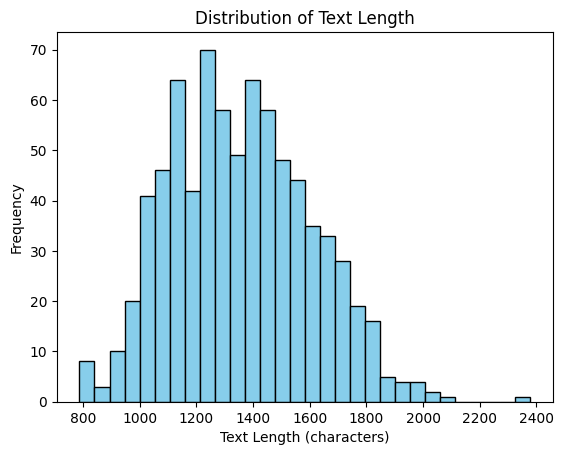

In [ ]:
df["length"] = df["origin_data"].apply(len) + df["anonymized_data"].apply(len)

import matplotlib.pyplot as plt

plt.hist(df["length"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Text Length")
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    max_seq_length=2400,
    peft_config=peft_config,
    tokenizer=tokenizer,
    packing=True,
)

trainer.train()

trainer.save_model(f"{save_dir}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length, packing. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:195: UserWarning: You passed a `packing` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
2,1.094400
4,0.913300
6,0.837700
8,0.802800
10,0.752600
12,0.690400
14,0.691900
16,0.664500
18,0.644700
20,0.667600


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


In [ ]:
del model
del tokenizer
torch.cuda.empty_cache()

In [ ]:
save_dir = "/workspace/FASTCAMPUS-CH09_11/chapter10-De_identification/model/model_0.0002_alpha-32_r-64"

In [ ]:
# 학습한 모델을 경로를 지정합니다.
peft_model_id = f"{save_dir}"

# PEFT 어댑터를 통해 사전 학습된 모델을 로드합니다.
fine_tuned_model = AutoPeftModelForCausalLM.from_pretrained(
  peft_model_id,
  device_map="auto",
  torch_dtype=torch.float16
).to("cuda")

# 토크나이저 로드합니다.
tokenizer = AutoTokenizer.from_pretrained(peft_model_id)
tokenizer.padding_side = 'right'
tokenizer.pad_token = tokenizer.eos_token


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
dataset["test"]

Dataset({
    features: ['messages', 'label'],
    num_rows: 78
})

In [ ]:
pipe = pipeline("text-generation", model=fine_tuned_model, tokenizer=tokenizer, device_map="auto")

prompt = pipe.tokenizer.apply_chat_template(dataset["test"][-2]["messages"][:2], tokenize=False, add_generation_prompt=True)
print(prompt)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCaus

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

너는 개인정보를 비식별화하는 Assistant야. 너는 주어진 데이터를 바탕으로 개인정보를 비식별화하는 작업을 해야해.<|eot_id|><|start_header_id|>user<|end_header_id|>

상담사: "안녕하세요, 김도현 고객님. 국민은행 홍길동 상담사입니다. 오늘 어떻게 도와드릴까요?"

고객: "안녕하세요. 제 계좌에 이상한 거래가 발생한 것 같아서요. 확인 좀 부탁드리려고요."

상담사: "네, 고객님. 불편을 드려 죄송합니다. 계좌번호와 생년월일을 알려주시면 거래 내역을 확인해 드리겠습니다."

고객: "계좌번호는 110-1234-5678이고, 제 생년월일은 1990년 5월 21일입니다."

상담사: "감사합니다. 지금 바로 확인해 보겠습니다. 혹시 최근에 고객님께서 기억에 없는 금액이 입출금된 것이 있었을까요?"

고객: "네, 어제 오후에 50만 원이 빠져나갔는데 제가 한 거래가 아니거든요."

상담사: "확인해보니, 010-1234-5678로 등록된 유선전화번호에서 요청된 이체로 보입니다. 이 번호가 고객님의 전화번호가 맞으신가요?"

고객: "네, 맞습니다. 다른 사람에게 공유한 적은 없어요."

상담사: "현재 저희 쪽에서 보안 절차를 강화해 드릴 수 있습니다. 몇 가지 추가 확인이 필요할 수 있으니 고객님의 이메일 주소를 알려주시면 필요한 정보를 보내드리겠습니다."

고객: "이메일은 kimdohyun@naver.com입니다."

상담사: "알겠습니다. 보안 조치를 강화하고, 의심되는 거래는 조사 후에 바로 연락드리겠습니다. 추가로 의심되는 거래가 없도록 카드 사용 내역과 계좌 비밀번호 변경을 권장드립니다."

고객: "네, 감사합니다. 바로 변경하겠습니다."

상담사: "네, 고객님. 빠른 시일 내에 다

In [ ]:
outputs = pipe(
    prompt,
    max_new_tokens=512,
    do_sample=False,
    temperature=0.1,
    top_k=40,
    top_p=0.1,
    eos_token_id=pipe.tokenizer.eos_token_id,
    pad_token_id=pipe.tokenizer.pad_token_id
)


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:623: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `40` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Starting from v4.46, the `logits` model output will have the same type as the model (except at train 

In [ ]:
output_text = outputs[0]["generated_text"][len(prompt):]
print(output_text)

상담사: "안녕하세요, [PERSON1] 고객님. 국민은행 [PERSON2] 상담사입니다. 오늘 어떻게 도와드릴까요?"

고객: "안녕하세요. 제 계좌에 이상한 거래가 발생한 것 같아서요. 확인 좀 부탁드리려고요."

상담사: "네, 고객님. 불편을 드려 죄송합니다. 계좌번호와 생년월일을 알려주시면 거래 내역을 확인해 드리겠습니다."

고객: "계좌번호는 [ACCOUNT1]이고, 제 생년월일은 [DATEOFBIRTH1]입니다."

상담사: "감사합니다. 지금 바로 확인해 보겠습니다. 혹시 최근에 고객님께서 기억에 없는 금액이 입출금된 것이 있었을까요?"

고객: "네, 어제 오후에 50만 원이 빠져나갔는데 제가 한 거래가 아니거든요."

상담사: "확인해보니, [CONTACT1]로 등록된 유선전화번호에서 요청된 이체로 보입니다. 이 번호가 고객님의 전화번호가 맞으신가요?"

고객: "네, 맞습니다. 다른 사람에게 공유한 적은 없어요."

상담사: "현재 저희 쪽에서 보안 절차를 강화해 드릴 수 있습니다. 몇 가지 추가 확인이 필요할 수 있으니 고객님의 이메일 주소를 알려주시면 필요한 정보를 보내드리겠습니다."

고객: "이메일은 [EMAIL1]입니다."

상담사: "알겠습니다. 보안 조치를 강화하고, 의심되는 거래는 조사 후에 바로 연락드리겠습니다. 추가로 의심되는 거래가 없도록 카드 사용 내역과 계좌 비밀번호 변경을 권장드립니다."

고객: "네, 감사합니다. 바로 변경하겠습니다."

상담사: "네, 고객님. 빠른 시일 내에 다시 연락드리겠습니다. 감사합니다. 좋은 하루 보내세요."

고객: "네, 수고하세요."


In [ ]:
input_text = dataset["test"][-2]["messages"][1]["content"]
print(input_text)

상담사: "안녕하세요, 김도현 고객님. 국민은행 홍길동 상담사입니다. 오늘 어떻게 도와드릴까요?"

고객: "안녕하세요. 제 계좌에 이상한 거래가 발생한 것 같아서요. 확인 좀 부탁드리려고요."

상담사: "네, 고객님. 불편을 드려 죄송합니다. 계좌번호와 생년월일을 알려주시면 거래 내역을 확인해 드리겠습니다."

고객: "계좌번호는 110-1234-5678이고, 제 생년월일은 1990년 5월 21일입니다."

상담사: "감사합니다. 지금 바로 확인해 보겠습니다. 혹시 최근에 고객님께서 기억에 없는 금액이 입출금된 것이 있었을까요?"

고객: "네, 어제 오후에 50만 원이 빠져나갔는데 제가 한 거래가 아니거든요."

상담사: "확인해보니, 010-1234-5678로 등록된 유선전화번호에서 요청된 이체로 보입니다. 이 번호가 고객님의 전화번호가 맞으신가요?"

고객: "네, 맞습니다. 다른 사람에게 공유한 적은 없어요."

상담사: "현재 저희 쪽에서 보안 절차를 강화해 드릴 수 있습니다. 몇 가지 추가 확인이 필요할 수 있으니 고객님의 이메일 주소를 알려주시면 필요한 정보를 보내드리겠습니다."

고객: "이메일은 kimdohyun@naver.com입니다."

상담사: "알겠습니다. 보안 조치를 강화하고, 의심되는 거래는 조사 후에 바로 연락드리겠습니다. 추가로 의심되는 거래가 없도록 카드 사용 내역과 계좌 비밀번호 변경을 권장드립니다."

고객: "네, 감사합니다. 바로 변경하겠습니다."

상담사: "네, 고객님. 빠른 시일 내에 다시 연락드리겠습니다. 감사합니다. 좋은 하루 보내세요."

고객: "네, 수고하세요."


In [ ]:
mapping_result = extract_placeholder_mapping(
    input_text,
    output_text,
    allowed_types=(
        "PERSON", "CONTACT", "ADDRESS", "ACCOUNT", "DATEOFBIRTH",
        "EMAIL", "LOCATION", "KAKO_ID", "TIWTTER_ID", "TELEGRAM_ID"))

print(mapping_result)

{'김도현': '[PERSON1]', '홍길동': '[PERSON2]', '110-1234-5678': '[ACCOUNT1]', '1990년 5월 21일': '[DATEOFBIRTH1]', '010-1234-5678': '[CONTACT1]', 'kimdohyun@naver.com': '[EMAIL1]'}
